In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_csv("C:\\Users\\Bala Vignesh.A\\Desktop\\SCMA 632\\assam data.csv", low_memory=False)

# Filter data for Assam

In [7]:
assam_data = data[data['state_1'] == 'ASSM']

# Check for missing values

In [5]:
missing_values = assam_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
slno              0
grp               0
Round_Centre      0
FSU_number        0
Round             0
                 ..
foodtotal_q       0
state_1           0
Region            0
fruits_df_tt_v    0
fv_tot            0
Length: 384, dtype: int64


# Replace missing values with mean

In [17]:
assam_data = assam_data.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

# Verify that there are no more missing values

In [18]:
missing_values_after = assam_data.isna().sum()
print("Missing values after replacement for Assam:")
print(missing_values_after)


Missing values after replacement for Assam:
slno              0
grp               0
Round_Centre      0
FSU_number        0
Round             0
                 ..
foodtotal_q       0
state_1           0
Region            0
fruits_df_tt_v    0
fv_tot            0
Length: 384, dtype: int64


# Identify and remove outliers using the IQR method

In [19]:
numeric_columns = assam_data.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    Q1 = assam_data[col].quantile(0.25)
    Q3 = assam_data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((assam_data[col] < (Q1 - 1.5 * IQR)) | (assam_data[col] > (Q3 + 1.5 * IQR)))
    print(f"{col} has {outliers.sum()} outliers in Assam")
    assam_data = assam_data[~outliers]

slno has 832 outliers in Assam
Round_Centre has 0 outliers in Assam
FSU_number has 0 outliers in Assam
Round has 0 outliers in Assam
Schedule_Number has 0 outliers in Assam
Sample has 0 outliers in Assam
Sector has 0 outliers in Assam
state has 0 outliers in Assam
State_Region has 0 outliers in Assam
District has 0 outliers in Assam
Stratum_Number has 0 outliers in Assam
Sub_Stratum has 0 outliers in Assam
Schedule_type has 0 outliers in Assam
Sub_Round has 0 outliers in Assam
Sub_Sample has 0 outliers in Assam
FOD_Sub_Region has 40 outliers in Assam
Hamlet_Group_Sub_Block has 0 outliers in Assam
t has 12 outliers in Assam
X_Stage_Stratum has 0 outliers in Assam
HHS_No has 155 outliers in Assam
Level has 0 outliers in Assam
Filler has 0 outliers in Assam
hhdsz has 58 outliers in Assam
NIC_2008 has 0 outliers in Assam
NCO_2004 has 146 outliers in Assam
HH_type has 103 outliers in Assam
Religion has 18 outliers in Assam
Social_Group has 0 outliers in Assam
Whether_owns_any_land has 104 o

# Check if the column exists and rename it

In [20]:
if 'old_district_column_name' in assam_data.columns:
    assam_data.rename(columns={'old_district_column_name': 'new_district_column_name'}, inplace=True)
else:
    print("Column 'old_district_column_name' doesn't exist in the data.")

Column 'old_district_column_name' doesn't exist in the data.


# Summarize the critical variables region-wise

In [21]:
region_summary = assam_data.groupby('FOD_Sub_Region').agg(
    avg_No_of_Meals_per_day=('No_of_Meals_per_day', 'mean'),
    min_No_of_Meals_per_day=('No_of_Meals_per_day', 'min'),
    max_No_of_Meals_per_day=('No_of_Meals_per_day', 'max')
).reset_index()


# Summarize the critical variables district-wise

In [22]:
district_summary = assam_data.groupby('District').agg(
    avg_No_of_Meals_per_day=('No_of_Meals_per_day', 'mean'),
    min_No_of_Meals_per_day=('No_of_Meals_per_day', 'min'),
    max_No_of_Meals_per_day=('No_of_Meals_per_day', 'max')
).reset_index()

# Mutate the District column

In [23]:
assam_data['District'] = assam_data['District'].apply(lambda x: 'ASSM Urban' if x == '18' else x)


# Identify the top and bottom three districts of consumption

In [24]:
top_three_districts = district_summary.sort_values(by='avg_No_of_Meals_per_day', ascending=False).head(3)
bottom_three_districts = district_summary.sort_values(by='avg_No_of_Meals_per_day').head(3)


# Inspect unique values in No_of_Meals_per_day for each District

In [42]:
unique_values_per_district = assam_data.groupby('District')['No_of_Meals_per_day'].unique()
print("Unique values of No_of_Meals_per_day for each District:")
for district, unique_values in unique_values_per_district.items():
    print(f"{district}: {unique_values}")

Unique values of No_of_Meals_per_day for each District:
19: [3.]
23: [3.]



# ANOVA analysis

In [35]:
import statsmodels.api as sm

In [39]:
from statsmodels.formula.api import ols

In [47]:
district_groups = [assam_data[assam_data['District'] == district]['No_of_Meals_per_day'].dropna() for district in assam_data['District'].unique()]
anova_result = f_oneway(*district_groups)

# Display ANOVA results

In [57]:
model = ols('No_of_Meals_per_day ~ (District)', data=assam_data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

In [58]:
print("ANOVA results:\n")
print(anova_result)

ANOVA results:

                sum_sq   df         F    PR(>F)
District  1.314768e-31  1.0  0.002545  0.967914
Residual  5.167039e-29  1.0       NaN       NaN


In [59]:
anova_summary = anova_result.reset_index()
anova_summary.columns = ['Source', 'sum_sq', 'df', 'F', 'PR(>F)']

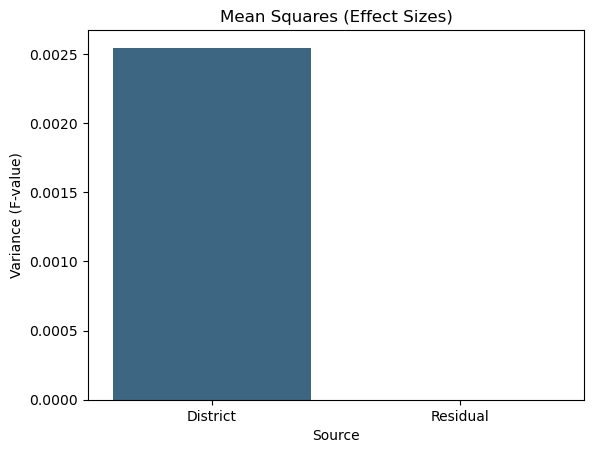

In [60]:
sns.barplot(x='Source', y='F', data=anova_summary, palette='viridis')
plt.title('Mean Squares (Effect Sizes)')
plt.xlabel('Source')
plt.ylabel('Variance (F-value)')
plt.show()

##In conclusion, the ANOVA results suggest that the District variable does not have a significant effect on the mean of No_of_Meals_per_day.

# Multiple Regression Analysis

In [1]:
import statsmodels.api as sm

# Define the dependent and independent variables

In [8]:
y = assam_data['No_of_Meals_per_day']
X = assam_data[['Region', 'District', 'FOD_Sub_Region', 'foodtotal_q', 'fv_tot']]


# Add a constant to the independent variables

In [9]:
X = sm.add_constant(X)

# Fit the multiple regression model

In [10]:
model = sm.OLS(y, X).fit()

# Print the regression summary

In [11]:
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     No_of_Meals_per_day   R-squared:                       0.043
Model:                             OLS   Adj. R-squared:                  0.042
Method:                  Least Squares   F-statistic:                     30.82
Date:                 Sat, 22 Jun 2024   Prob (F-statistic):           8.96e-31
Time:                         11:06:48   Log-Likelihood:                -1688.5
No. Observations:                 3440   AIC:                             3389.
Df Residuals:                     3434   BIC:                             3426.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.1341      0.2

# Regression Diagnostics

### 1. Linearity

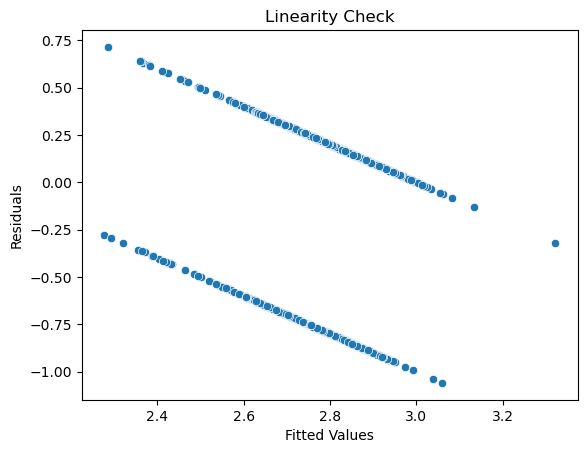

In [13]:
sns.scatterplot(x=model.fittedvalues, y=model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Linearity Check')
plt.show()

### 2. Homoscedasticity

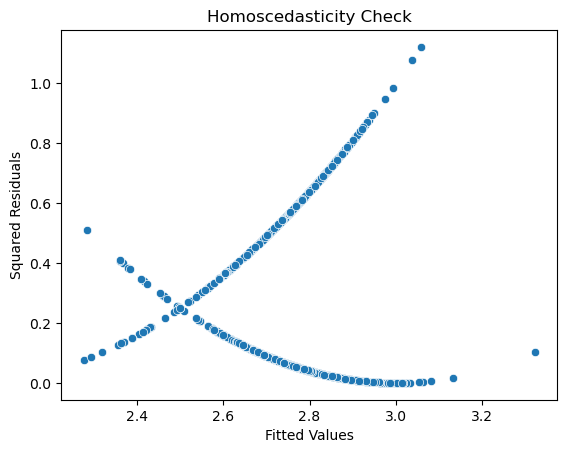

In [14]:
sns.scatterplot(x=model.fittedvalues, y=model.resid**2)
plt.xlabel('Fitted Values')
plt.ylabel('Squared Residuals')
plt.title('Homoscedasticity Check')
plt.show()

### 3. Normality of Residuals

C:\Users\Bala Vignesh.A\AppData\Local\Temp\ipykernel_10916\1671985890.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model.resid, kde=False)


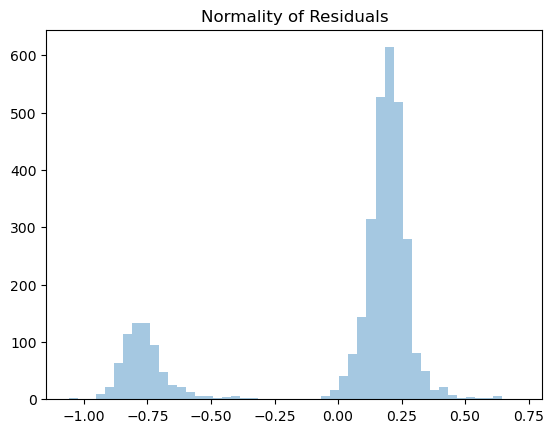

In [15]:
sns.distplot(model.resid, kde=False)
plt.title('Normality of Residuals')
plt.show()

### 4. Multicollinearity

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
print(vif)

           VIF        features
0  1570.068655           const
1     1.016722          Region
2     1.014632        District
3     1.006422  FOD_Sub_Region
4     1.729858     foodtotal_q
5     1.734250          fv_tot


### 5. Autocorrelation

In [17]:
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_stat}')

Durbin-Watson statistic: 1.1286483339416855
